In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from defDef import *
from fredapi import Fred
import seaborn as sns
import scipy.stats as stats
from scipy.stats import linregress

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

# print 옵션
# pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.width', None)  # 열(칼럼) 생략없이
# pd.set_option('display.max_row', None)  # 행 생략없이

In [28]:
# ----------------------------------------------------------------------------
# Fred API 데이터분석 수집
# ----------------------------------------------------------------------------
# 시리즈 ID
'''
T10Y2Y : 장단기금리차 10-2 (Daily)
FEDFUNDS : 연준 기준금리 (Monthly)
UNRATE : 실업률 (Monthly)
PAYEMS : 비농업고용지표
CPIAUCSL : CPI (Monthly)
PCE : PCE (Monthly)
DEXJPUS : 달러엔 (Daily)
DEXSZUS : 달러프랑 (Daily)
T5YIFR : 5Y5Y forward inflation expectation (Daily)
T5YIE : 5년 기대 인플레이션 (Daily)
T10YIE : 10년 기대 인플레이션 (Daily)
GDPPOT : 잠재GDP (Quarterly)
OUTPUTGAP : GDPC1(실질GPD) - GDPPOT(잠재GDP) (Quarterly)
REAINTRATREARAT10Y : 10년물 실질금리 (Monthly)
POILWTIUSDM : WTI (Monthly)
PCOPPUSDM : COPPER (Monthly)
POP : 총인구 (Monthly)
NETEXP : 무역적자 (Quarterly)
RSXFS : 소매판매지표 (Monthly)
'''

# 사용자 변수
code_lst = ['T10Y2Y', 'FEDFUNDS', 'UNRATE', 'PAYEMS', 'CPIAUCSL', 'PCE', 'DEXJPUS', 'DEXSZUS', 'T5YIFR', 'T5YIE', 'T10YIE', 'GDPPOT', 'OUTPUTGAP', 'REAINTRATREARAT10Y', 'POILWTIUSDM', 'PCOPPUSDM', 'POP', 'NETEXP', 'RSXFS', 'VIX']
save_name_lst = ['장단기금리차', '기준금리', '실업률', '비농업고용지표', 'CPI', 'PCE', '달러엔', '달러프랑', '5년포워드인플레이션', '5년기대인플레이션', '10년기대인플레이션', '잠재GDP', 'OUTPUTGAP', '실질금리10년물', 'WTI', 'COPPER', 'POP', '무역적자', '소매판매지표', 'VIX']
if len(code_lst) != len(save_name_lst): print('err')
code_dict  = {}  # 시각화 위함
for i in range(len(code_lst)):
    code_dict.update({save_name_lst[i] : code_lst[i]})

# Fred API key
fred = Fred(api_key='aa31e4dec2cd4970f449c9cf1891fcbd')

In [29]:
# Fred API로 매크로 지표 수집
fred_case = 0
if fred_case == 1:
    for i in range(len(code_lst)):
        print(code_lst[i])
        
        if code_lst[i] == 'OUTPUTGAP':
            data1 = fred.get_series('GDPC1')  # real
            data1 = FredDefColl.data_preprocessing(data1)
            df1 = pd.DataFrame(data1)

            data2 = fred.get_series('GDPPOT')  # pot
            data2 = FredDefColl.data_preprocessing(data2)
            df2 = pd.DataFrame(data2)

            df1, df2 = og_DefColl.df_intersection(df1, df2)

            df = pd.DataFrame({'datetime':df1['datetime'], 'c':df1['c'] - df2['c']})

        else:
            data = fred.get_series(code_lst[i])
            # data = FredDefColl.get_series_as_of_date(series_id, '2024/03/10')

            # 전처리
            data = FredDefColl.data_preprocessing(data)

            df = pd.DataFrame(data)

        # 2. CSV 파일로 저장
        print(df)
        df.to_csv(f'D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\\macro\\{save_name_lst[i]}.csv', index=False)

In [30]:
# ----------------------------------------------------------------------------
# 데이터 전처리
# ----------------------------------------------------------------------------
'''
0. 데이터 불러오기
1. timeFrame 변환 : Daily to Monthly, Quarterly fillna to Monthly
2. 증감률, 모멘텀 계산
3. 모든 데이터 날짜 동기화
'''

'\n0. 데이터 불러오기\n1. timeFrame 변환 : Daily to Monthly, Quarterly fillna to Monthly\n2. 증감률, 모멘텀 계산\n3. 모든 데이터 날짜 동기화\n'

In [31]:
# 0. 데이터 불러오기
# 데이터가 저장된 디렉토리 경로
directory = r"D:\doyun\green-data-analysis2\teamwork\project5\data\macro"

# 디렉토리 내의 모든 파일을 저장할 리스트
dfs_lst = []
code_lst = [v.replace('.csv', '') for v in os.listdir(directory)]

# 디렉토리 내의 파일들을 반복하여 처리
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    df = FredDefColl.df_preprocessing(pd.read_csv(file_path))
    dfs_lst.append(df)

# s&p 500
code_lst.append('SP500')
dfs_lst.append(FredDefColl.df_preprocessing(og_DefColl.preprocess_df(pd.read_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\\index\\월 S&P 500 70.02~24.02.csv'))))
# GD
code_lst.append('GD')
dfs_lst.append(FredDefColl.df_preprocessing(og_DefColl.preprocess_df(pd.read_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\\futures\\월 금 선물 80.08~24.02.csv'))))

# code_dict
code_dict.update({'SP500':'SP500'})
# code_dict.update({'TLT':'TLT'})
code_dict.update({'y10':'y10'})
code_dict.update({'GD':'GD'})

# TLT
code_lst.append('y10')
dfs_lst.append(FredDefColl.df_preprocessing(og_DefColl.preprocess_df(pd.read_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\\spot\\월 TLT 05.06~24.02.csv'))))

# # y10
# code_lst.append('y10')
# dfs_lst.append(FredDefColl.df_preprocessing(og_DefColl.preprocess_df(pd.read_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\\futures\\일 10y 82.05.03~23.07.11.csv'))))

In [32]:
# 첫 번째 행과 두 번째 행의 날짜 차이 구하기
day_diff_lst = []
for _df in dfs_lst:
    date_diff = _df.loc[1, 'datetime'] - _df.loc[0, 'datetime']
    day_diff_lst.append(date_diff.days)

for i in range(len(dfs_lst)):
    # print(code_lst[i])

    # 1. timeFrame 변환
    # Daily to Monthly
    if day_diff_lst[i] <= 7:  # Daily
        dfs_lst[i] = FredDefColl.day_to_weekmonth_without_keytype(df=dfs_lst[i], to='M')  # to Monthly
        dfs_lst[i] = FredDefColl.find_change(dfs_lst[i])  # 직전대비 증감률
        dfs_lst[i] = FredDefColl.find_change_year(dfs_lst[i])  # 전년대비 증감률
    # Quarterly fillna
    elif day_diff_lst[i] > 31:  # Quarterly
        dfs_lst[i] = FredDefColl.find_change(dfs_lst[i])  # 직전대비 증감률
        dfs_lst[i] = FredDefColl.fill_nan_datetime(dfs_lst[i])  # to Monthly
        dfs_lst[i] = FredDefColl.find_change_year(dfs_lst[i])  # 전년대비 증감률
    else:
        pass
        dfs_lst[i] = FredDefColl.find_change(dfs_lst[i])  # 직전대비 증감률
        dfs_lst[i] = FredDefColl.find_change_year(dfs_lst[i])  # 전년대비 증감률
    
    # 2. 전년대비 증감률 모멘텀 계산
    if 1==2:
        if code_lst[i] in ['잠재GDP', '무역적자']:  # if Quarterly
            dfs_lst[i]['ams'] = og_Calculator.average_momentum_score(data_list=dfs_lst[i]['change_year'], momentump_list=[4, 8, 12], nan치환값=np.nan)
            # plt.plot(dfs_lst[i]['datetime'], dfs_lst[i]['change_year'])
            # plt.plot(dfs_lst[i]['datetime'], dfs_lst[i]['ams'])
        elif code_lst[i] in ['POP', '소매판매지표', 'CPI', 'PCE']:  # if not Quarterly
            dfs_lst[i]['ams'] = og_Calculator.average_momentum_score(data_list=dfs_lst[i]['change_year'], momentump_list=list(range(1, 12)), nan치환값=np.nan)
            # plt.plot(dfs_lst[i]['datetime'], dfs_lst[i]['change_year'])
            # plt.plot(dfs_lst[i]['datetime'], dfs_lst[i]['ams'])

    dfs_lst[i] = dfs_lst[i].dropna()

    # 데이터 시각화
    # plt.plot(dfs_lst[i]['datetime'], dfs_lst[i]['change_year'])
    # plt.show()

# 3. 모든 데이터 날짜 동기화
# merge위해 컬럼명, datetime 변경
for i in range(len(dfs_lst)):
    # cols = ['datetime'] + [f'{code_lst[i][:6]}_{v}' for v in dfs_lst[i].columns if v != 'datetime']  # 한국어
    cols = ['datetime'] + [f'{code_dict[code_lst[i]][:6]}_{v}' for v in dfs_lst[i].columns if v != 'datetime']  # series_id
    dfs_lst[i].columns = cols
    dfs_lst[i]['datetime'] = pd.to_datetime(dfs_lst[i]['datetime'].dt.strftime('%Y-%m-01'))  # -01로 일치

df = dfs_lst[0]
for i, _df in enumerate(dfs_lst[1:]):
    df = pd.merge(df, _df, on='datetime', how='inner')
df = df.dropna()

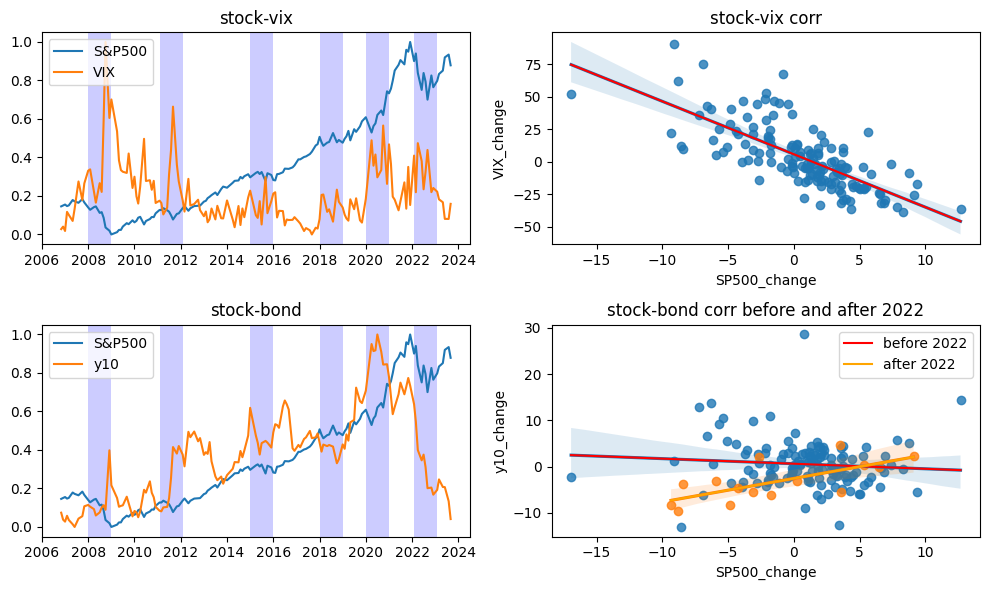

In [33]:
# ----------------------------------------------------------------------------
# 데이터 분석 & 시각화
# ----------------------------------------------------------------------------

# 하락장
bear_idx_lst = []
for i in range(len(df)):
    if df['datetime'][i].year in [2008, 2011, 2015, 2018, 2020, 2022]:
        bear_idx_lst.append(i)

# 주식-변동성 지수
plt.figure(figsize=(10, 6))

plt.subplot(2,2,1)
plt.title('stock-vix')
plt.plot(df['datetime'], MinMaxScaler().fit_transform(df[['SP500_c']]), label='S&P500')
plt.plot(df['datetime'], MinMaxScaler().fit_transform(df[['VIX_c']]), label='VIX')
for i in bear_idx_lst:
    plt.axvspan(df['datetime'][i], df['datetime'][i+1], facecolor='b', alpha=0.2)
plt.legend(loc='upper left')

# 주식-변동성 지수 상관관계
plt.subplot(2,2,2)
plt.title('stock-vix corr')

x_col = 'SP500_change'
y_col = 'VIX_change'

lin_data = {
    x_col: df[x_col],
    y_col: df[y_col]
}
lin_df = pd.DataFrame(lin_data).dropna()

slope, intercept, r_value, p_value, std_err = stats.linregress(lin_df[x_col], lin_df[y_col])  # df['overnight'] 마지막행이 nan이므로 -1 행 제외

# 산점도 그리기
sns.regplot(x=x_col, y=y_col, data=lin_df, scatter=True)
# 선형 회귀 직선 그리기
slope, intercept, _, _, _ = linregress(lin_df[x_col], lin_df[y_col])
x_values = np.array([min(lin_df[x_col]), max(lin_df[x_col])])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, color='red')


# 주식-채권 지수
plt.subplot(2,2,3)
plt.title('stock-bond')

# df = df.copy()
# df, y10 = DefColl.sync_dfs_lst([df, y10]) 
# df['y10_c'] = y10['c']
# df['y10_change'] = df['y10_c'].diff() / df['y10_c'].shift()

plt.plot(df['datetime'], MinMaxScaler().fit_transform(df[['SP500_c']]), label='S&P500')
plt.plot(df['datetime'], MinMaxScaler().fit_transform(df[['y10_c']]), label='y10')

for i in bear_idx_lst:
    plt.axvspan(df['datetime'][i], df['datetime'][i+1], facecolor='b', alpha=0.2)
plt.legend(loc='upper left')

plt.subplot(2,2,4)
plt.title('stock-bond corr before and after 2022')

x_col = 'SP500_change'
y_col = 'y10_change'

lin_data = {
    x_col: df[df['datetime'].dt.year < 2022][x_col],
    y_col: df[df['datetime'].dt.year < 2022][y_col]
}
lin_df = pd.DataFrame(lin_data).dropna()

slope, intercept, r_value, p_value, std_err = stats.linregress(lin_df[x_col], lin_df[y_col])  # df['overnight'] 마지막행이 nan이므로 -1 행 제외

# 산점도 그리기
sns.regplot(x=x_col, y=y_col, data=lin_df, scatter=True)
# 선형 회귀 직선 그리기
slope, intercept, _, _, _ = linregress(lin_df[x_col], lin_df[y_col])
x_values = np.array([min(lin_df[x_col]), max(lin_df[x_col])])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, color='red', label='before 2022')

lin_data = {
    x_col: df[df['datetime'].dt.year >= 2022][x_col],
    y_col: df[df['datetime'].dt.year >= 2022][y_col]
}
lin_df = pd.DataFrame(lin_data).dropna()

slope, intercept, r_value, p_value, std_err = stats.linregress(lin_df[x_col], lin_df[y_col])  # df['overnight'] 마지막행이 nan이므로 -1 행 제외

# 산점도 그리기
sns.regplot(x=x_col, y=y_col, data=lin_df, scatter=True)
# 선형 회귀 직선 그리기
slope, intercept, _, _, _ = linregress(lin_df[x_col], lin_df[y_col])
x_values = np.array([min(lin_df[x_col]), max(lin_df[x_col])])
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, color='orange', label='after 2022')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

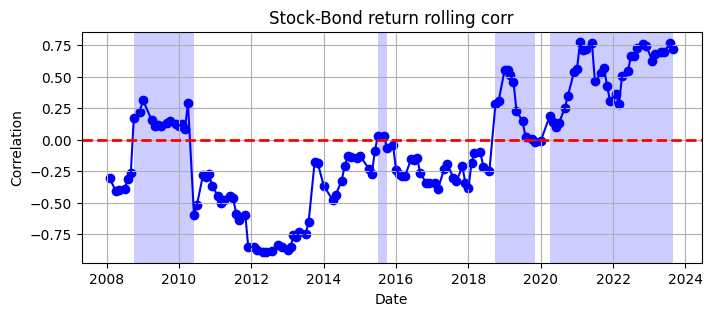

In [34]:
# 주식-채권
x_col = 'SP500_change'
y_col = 'y10_change'

# 두 컬럼 간의 상관관계 계산
stock_bond_correlation = df[x_col].rolling(window=12).corr(df[y_col])

# 나쁜 상관관계
bad_corr_lst = []
for i in range(len(stock_bond_correlation)):
    if stock_bond_correlation[i] >= 0 and i+1 < len(df):
        bad_corr_lst.append(i)

# 주식-채권 상관관계
plt.figure(figsize=(8, 3))
plt.title('Stock-Bond return rolling corr')
plt.plot(df['datetime'], stock_bond_correlation, color='blue', label='Correlation')
plt.scatter(df['datetime'], stock_bond_correlation, color='blue')
plt.xlabel('Date')
plt.ylabel('Correlation')
# plt.legend(loc='best')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero Line')
for i in bad_corr_lst:  # bear_idx_lst, bad_corr_lst
    # y 값이 0 이하인 경우에만 axvspan 호출
    plt.axvspan(df['datetime'][i], df['datetime'][i+1], facecolor='b', alpha=0.2)

plt.grid(True)
plt.show()


x,y_선형회기
x: T5YIFR_c_x y: stock_bond_correlation_y
기울기: -0.43
절편: 0.88
상관 계수: -0.34
p-value: 0.0
표준 오차: 0.1


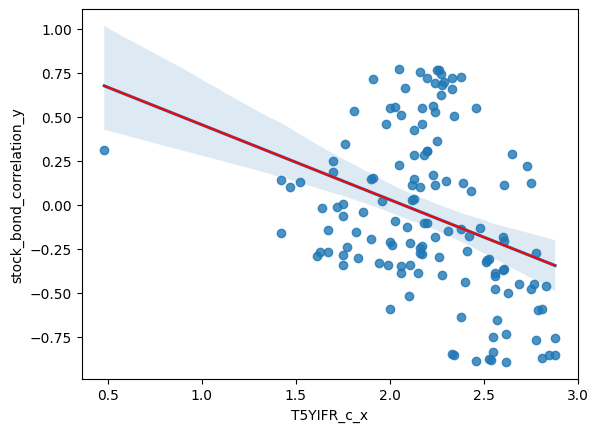


x,y_선형회기
x: CPIAUC_c_x y: stock_bond_correlation_y
기울기: 0.01
절편: -3.28
상관 계수: 0.69
p-value: 0.0
표준 오차: 0.0


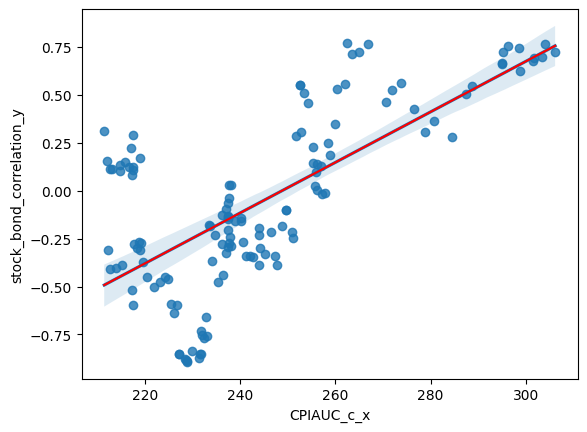


x,y_선형회기
x: CPIAUC_change_year_x y: stock_bond_correlation_y
기울기: 7.44
절편: -0.24
상관 계수: 0.35
p-value: 0.0
표준 오차: 1.71


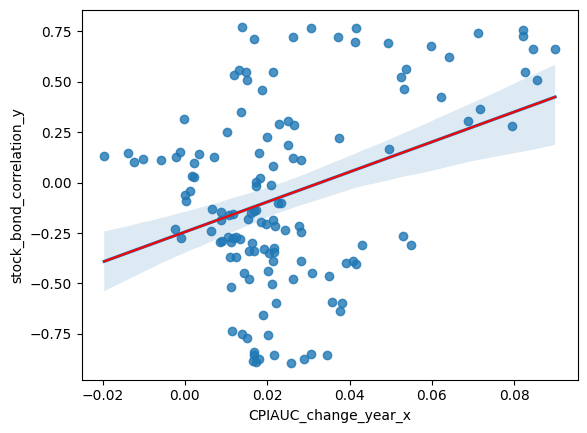


x,y_선형회기
x: OUTPUT_c_x y: stock_bond_correlation_y
기울기: 0.0
절편: 0.08
상관 계수: 0.33
p-value: 0.0
표준 오차: 0.0


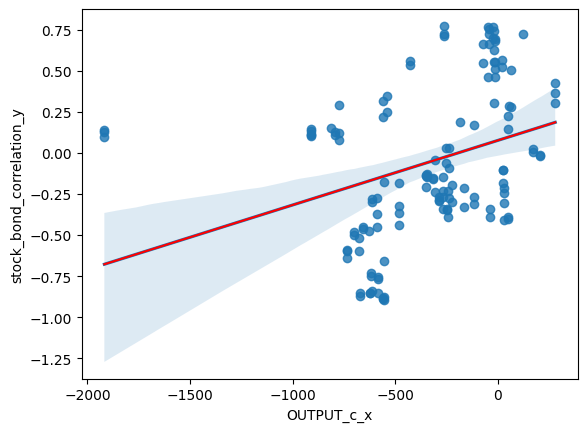


x,y_선형회기
x: PCE_c_x y: stock_bond_correlation_y
기울기: 0.0
절편: -1.78
상관 계수: 0.71
p-value: 0.0
표준 오차: 0.0


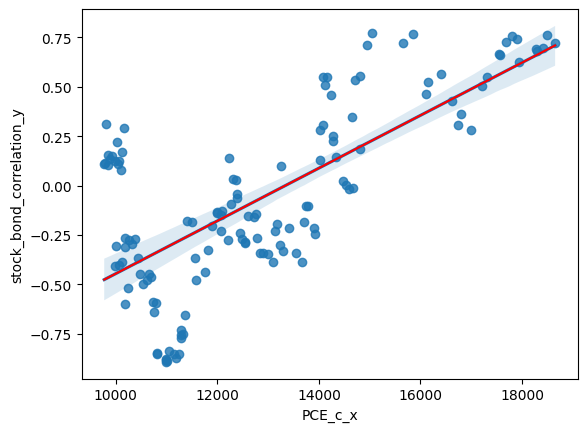


x,y_선형회기
x: POP_c_x y: stock_bond_correlation_y
기울기: 0.0
절편: -9.78
상관 계수: 0.62
p-value: 0.0
표준 오차: 0.0


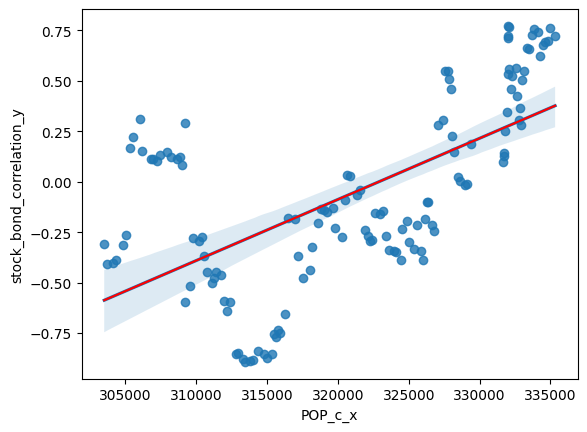


x,y_선형회기
x: POP_change_year_x y: stock_bond_correlation_y
기울기: -90.18
절편: 0.54
상관 계수: -0.39
p-value: 0.0
표준 오차: 18.65


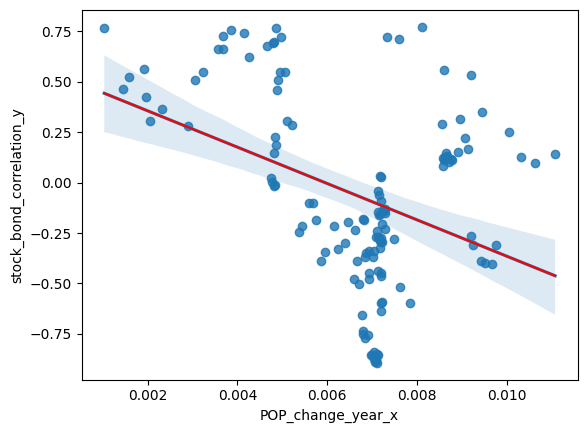


x,y_선형회기
x: FEDFUN_c_x y: stock_bond_correlation_y
기울기: 0.16
절편: -0.2
상관 계수: 0.42
p-value: 0.0
표준 오차: 0.03


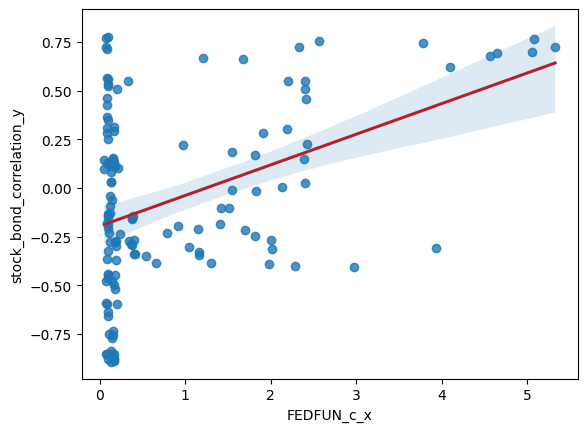


x,y_선형회기
x: FEDFUN_change_year_x y: stock_bond_correlation_y
기울기: 0.02
절편: -0.11
상관 계수: 0.37
p-value: 0.0
표준 오차: 0.0


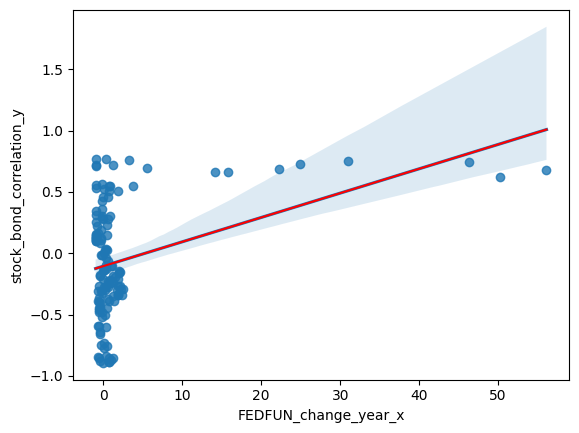


x,y_선형회기
x: DEXJPU_c_x y: stock_bond_correlation_y
기울기: 0.02
절편: -2.1
상관 계수: 0.67
p-value: 0.0
표준 오차: 0.0


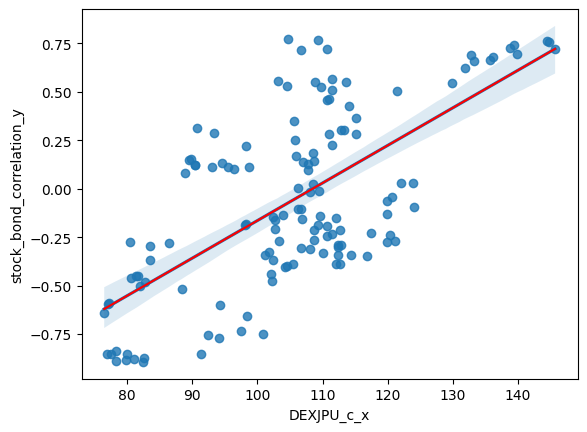


x,y_선형회기
x: NETEXP_c_x y: stock_bond_correlation_y
기울기: -0.0
절편: -1.11
상관 계수: -0.58
p-value: 0.0
표준 오차: 0.0


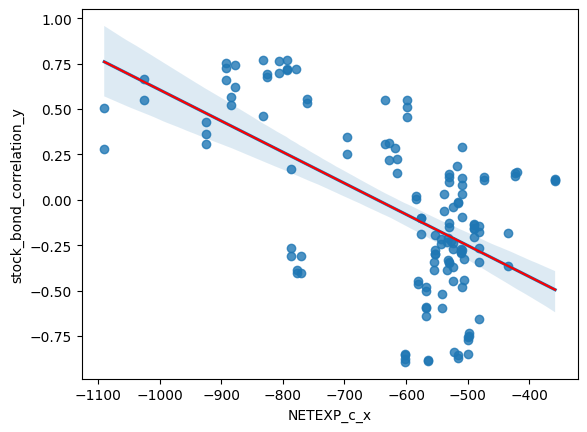


x,y_선형회기
x: PAYEMS_c_x y: stock_bond_correlation_y
기울기: 0.0
절편: -5.03
상관 계수: 0.59
p-value: 0.0
표준 오차: 0.0


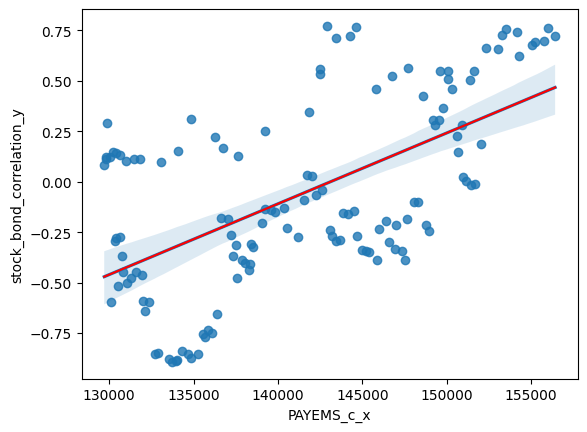


x,y_선형회기
x: RSXFS_c_x y: stock_bond_correlation_y
기울기: 0.0
절편: -1.59
상관 계수: 0.7
p-value: 0.0
표준 오차: 0.0


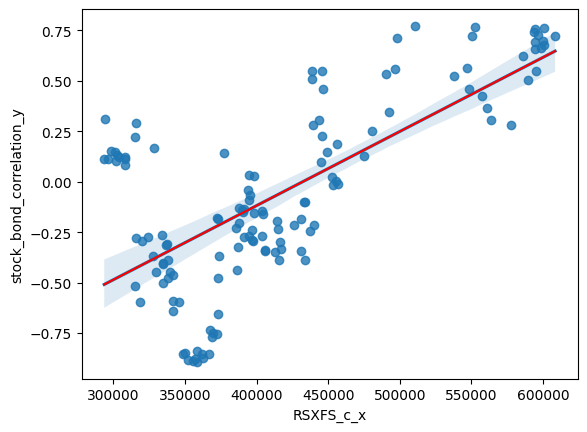


x,y_선형회기
x: UNRATE_c_x y: stock_bond_correlation_y
기울기: -0.07
절편: 0.39
상관 계수: -0.37
p-value: 0.0
표준 오차: 0.02


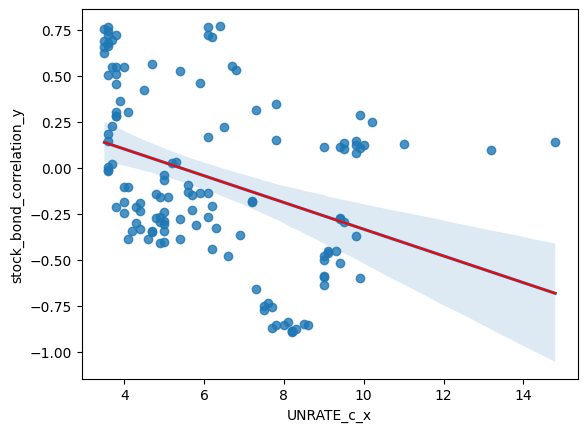


x,y_선형회기
x: GDPPOT_c_x y: stock_bond_correlation_y
기울기: 0.0
절편: -3.83
상관 계수: 0.69
p-value: 0.0
표준 오차: 0.0


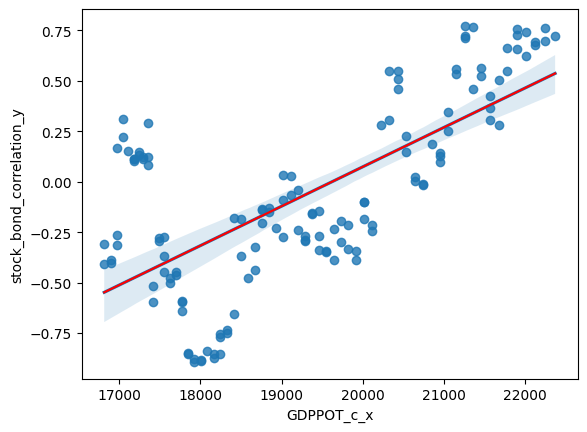


x,y_선형회기
x: GDPPOT_change_x y: stock_bond_correlation_y
기울기: 4.1
절편: -1.95
상관 계수: 0.43
p-value: 0.0
표준 오차: 0.75


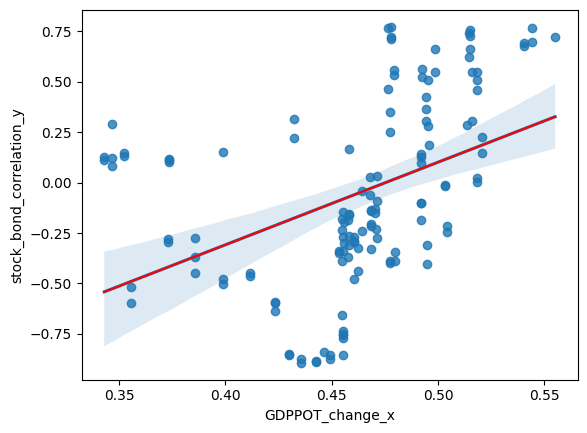


x,y_선형회기
x: GDPPOT_change_year_x y: stock_bond_correlation_y
기울기: 125.21
절편: -2.38
상관 계수: 0.5
p-value: 0.0
표준 오차: 18.8


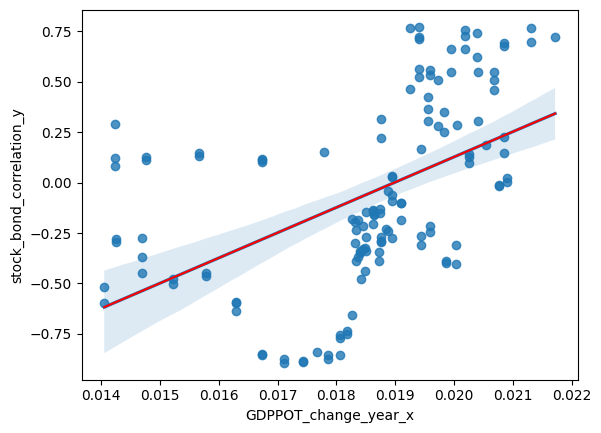


x,y_선형회기
x: T10Y2Y_c_x y: stock_bond_correlation_y
기울기: -0.26
절편: 0.27
상관 계수: -0.54
p-value: 0.0
표준 오차: 0.04


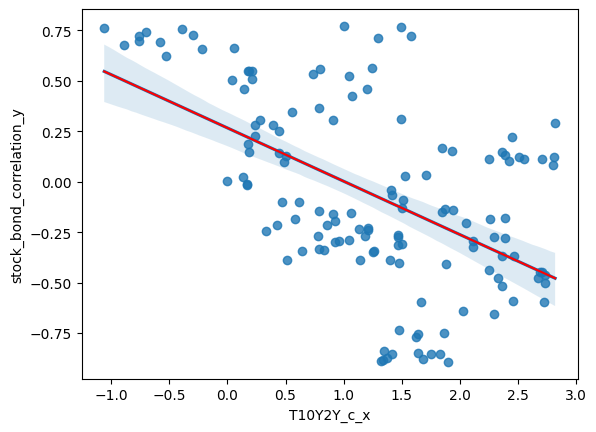


x,y_선형회기
x: SP500_c_x y: stock_bond_correlation_y
기울기: 0.0
절편: -0.77
상관 계수: 0.72
p-value: 0.0
표준 오차: 0.0


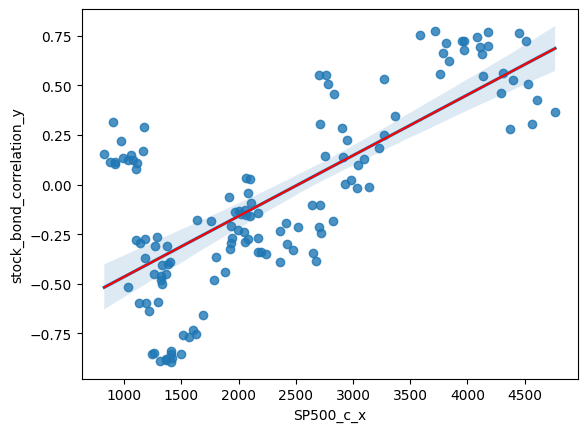


x,y_선형회기
x: y10_change_year_x y: stock_bond_correlation_y
기울기: -1.11
절편: -0.03
상관 계수: -0.39
p-value: 0.0
표준 오차: 0.23


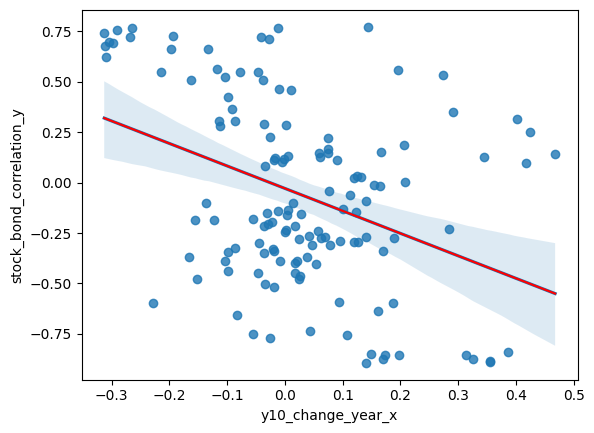

[('SP500_c', 0.7234280930504841), ('PCE_c', 0.7140613231211581), ('RSXFS_c', 0.7009130236932585), ('CPIAUC_c', 0.6922413018873925), ('GDPPOT_c', 0.6907393477060919), ('DEXJPU_c', 0.6669745158753883), ('POP_c', 0.621824313762345), ('PAYEMS_c', 0.5917661003825118), ('NETEXP_c', -0.58098231128084), ('T10Y2Y_c', -0.538312696211943), ('GDPPOT_change_year', 0.500139343277522), ('GDPPOT_change', 0.4269709310173572), ('FEDFUN_c', 0.41700235582153805), ('y10_change_year', -0.39145989522951974), ('POP_change_year', -0.3867384813618837), ('UNRATE_c', -0.37219165280630573), ('FEDFUN_change_year', 0.36891898307074505), ('CPIAUC_change_year', 0.3524454797162624), ('T5YIFR_c', -0.3448693381518025), ('OUTPUT_c', 0.33171390277510776)]
['SP500_c', 'PCE_c', 'RSXFS_c', 'CPIAUC_c', 'GDPPOT_c', 'DEXJPU_c', 'POP_c', 'PAYEMS_c', 'NETEXP_c', 'T10Y2Y_c', 'GDPPOT_change_year', 'GDPPOT_change', 'FEDFUN_c', 'y10_change_year', 'POP_change_year', 'UNRATE_c', 'FEDFUN_change_year', 'CPIAUC_change_year', 'T5YIFR_c', 'O

In [35]:
# 선형 회귀 분석

corr_lst = []

for col in df.columns:
    if col != 'datetime':
        x_col = col
        y_col = 'stock_bond_correlation'

        lin_data = {
            x_col + '_x': df[x_col],

            y_col + '_y': stock_bond_correlation.shift(-1)
        }
        lin_df = pd.DataFrame(lin_data).dropna()

        slope, intercept, r_value, p_value, std_err = stats.linregress(lin_df[x_col + '_x'], lin_df[y_col + '_y'])  # df['overnight'] 마지막행이 nan이므로 -1 행 제외

        corr_lst.append((col, r_value))

        if 1==1 and abs(r_value) >= 0.3:
            # 출력
            print('\nx,y_선형회기')
            print('x:', x_col + '_x', 'y:', y_col + '_y')
            print("기울기:", round(slope, 2))
            print("절편:", round(intercept, 2))
            print("상관 계수:", round(r_value, 2))
            print("p-value:", round(p_value, 2))
            print("표준 오차:", round(std_err, 2))

            # 산점도 그리기
            sns.regplot(x=x_col + '_x', y=y_col + '_y', data=lin_df, scatter=True)
            # 선형 회귀 직선 그리기
            slope, intercept, _, _, _ = linregress(lin_df[x_col + '_x'], lin_df[y_col + '_y'])
            x_values = np.array([min(lin_df[x_col + '_x']), max(lin_df[x_col + '_x'])])
            y_values = slope * x_values + intercept
            plt.plot(x_values, y_values, color='red')
            plt.show()
    else:
        corr_lst.append((col, np.nan))

corr_lst = sorted(corr_lst, key=lambda x: abs(x[1]), reverse=True)
# print(corr_lst)
filtered_data = [(col, r_value) for col, r_value in corr_lst if abs(r_value) >= 0.3]
print(filtered_data)
selected_col = [col for col, _ in filtered_data]
print(selected_col, len(selected_col))


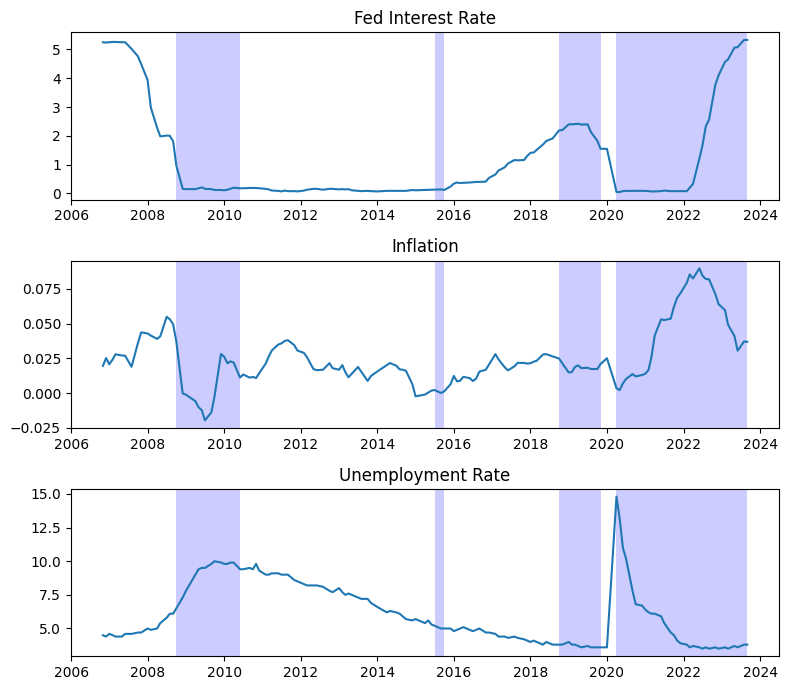

In [36]:
# 기준금리
plt.figure(figsize=(8, 7))
plt.subplot(3,1,1)
plt.title('Fed Interest Rate')
plt.plot(df['datetime'], df['FEDFUN_c'])
for i in bad_corr_lst:  # bear_idx_lst, bad_corr_lst
    # y 값이 0 이하인 경우에만 axvspan 호출
    plt.axvspan(df['datetime'][i], df['datetime'][i+1], facecolor='b', alpha=0.2)

# 물가 상승률
plt.subplot(3,1,2)
plt.title('Inflation')
plt.plot(df['datetime'], df['CPIAUC_change_year'])
for i in bad_corr_lst:  # bear_idx_lst, bad_corr_lst
    # y 값이 0 이하인 경우에만 axvspan 호출
    plt.axvspan(df['datetime'][i], df['datetime'][i+1], facecolor='b', alpha=0.2)

# 실업률
plt.subplot(3,1,3)
plt.title('Unemployment Rate')
plt.plot(df['datetime'], df['UNRATE_c'])
for i in bad_corr_lst:  # bear_idx_lst, bad_corr_lst
    # y 값이 0 이하인 경우에만 axvspan 호출
    plt.axvspan(df['datetime'][i], df['datetime'][i+1], facecolor='b', alpha=0.2)

plt.tight_layout()
plt.show()

In [37]:
# ----------------------------------------------------------------------------
# train_test_split
# ----------------------------------------------------------------------------
# y 레이블링
df['correlation'] = stock_bond_correlation
df['y'] = df['correlation'].shift(-1)

# y값 설정
# 범주화
df['y'] = df['y'].map(lambda v: 1 if v >= 0 else 0)  # 상승하락 예측

# nan값 제거
# 무한대 값을 NaN으로 대체
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# NaN 값을 포함하는 행 제거
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

# X, y
train_test_case = 1
# selected_col = [col for col in df.columns if col not in ['datetime', 'y', 'correlation']]
selected_col = [col for col in df.columns if col not in ['datetime', 'y']]
random_state = 42

if train_test_case == 1:  # train_test_split
    X = df[selected_col].values
    y = df['y'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=random_state)

elif train_test_case == 2 : # 직접
    # datetime 컬럼을 기준으로 train과 test 데이터프레임을 분리

    train_df = df[df['datetime'].dt.year < 2022]
    test_df = df[df['datetime'].dt.year >= 2022]

    # train 데이터프레임 출력
    print("Train 데이터프레임:")
    print(train_df.head())

    # test 데이터프레임 출력
    print("\nTest 데이터프레임:")
    print(test_df.head())

    X_train, X_test, y_train, y_test = train_df[selected_col].values, test_df[selected_col], train_df['y'], test_df['y']


In [38]:
# ----------------------------------------------------------------------------
# 클래스 분포
# ----------------------------------------------------------------------------
# 'y' 값이 1 이상인 것과 이하인 것의 개수 계산
y_values = y_train
count_y_above_1 = np.sum(y_values >= 1)
count_y_below_1 = np.sum(y_values < 1)
total_count = len(y_values)

# 비율 계산
ratio_y_above_1 = count_y_above_1 / total_count
ratio_y_below_1 = count_y_below_1 / total_count

print("train y 값이 1 이상인 비율:", ratio_y_above_1, '% /', count_y_above_1, '개')
print("train y 값이 1 이하인 비율:", ratio_y_below_1, '% /', count_y_below_1, '개')

# 'y' 값이 1 이상인 것과 이하인 것의 개수 계산
y_values = y_test
count_y_above_1 = np.sum(y_values >= 1)
count_y_below_1 = np.sum(y_values < 1)
total_count = len(y_values)

# 비율 계산
ratio_y_above_1 = count_y_above_1 / total_count
ratio_y_below_1 = count_y_below_1 / total_count

print("test y 값이 1 이상인 비율:", ratio_y_above_1, '% /', count_y_above_1, '개')
print("test y 값이 1 이하인 비율:", ratio_y_below_1, '% /', count_y_below_1, '개')

train y 값이 1 이상인 비율: 0.42574257425742573 % / 43 개
train y 값이 1 이하인 비율: 0.5742574257425742 % / 58 개
test y 값이 1 이상인 비율: 0.4411764705882353 % / 15 개
test y 값이 1 이하인 비율: 0.5588235294117647 % / 19 개


In [39]:
# ----------------------------------------------------------------------------
# 모델 평가
# ----------------------------------------------------------------------------
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, make_scorer, f1_score

def get_model():

    rfc = RandomForestClassifier(n_estimators=1, criterion='entropy', bootstrap=False, class_weight='balanced_subsample')
    model = BaggingClassifier(estimator=rfc, n_estimators=1000, max_features=1.)
        
    return model

# 모델 평가
def get_score(model, X_train, y_train, X_test, y_test):

    # 모델 초기화
    model = get_model()

    # KFold 객체 생성
    kf = KFold(n_splits=5, shuffle=False)

    # 교차 검증 수행 (훈련 데이터셋으로)
    scoring = {'precision':make_scorer(precision_score, pos_label=1), 'recall':make_scorer(recall_score, pos_label=1)}
    cv_results = cross_validate(model, X_train, y_train, cv=kf, scoring=scoring)

    # 교차 검증 결과 출력
    print('Train CV 모델 평가')
    print("평균 정밀도:", np.mean(cv_results['test_precision']))
    print("최고 정밀도:", np.max(cv_results['test_precision']))
    print("최저 정밀도:", np.min(cv_results['test_precision']))
    print()
    print("평균 재현율:", np.mean(cv_results['test_recall']))
    print("최고 재현율:", np.max(cv_results['test_recall']))
    print("최저 재현율:", np.min(cv_results['test_recall']))
    print()

    # 모델 초기화
    model = get_model()

    # 모델 훈련 (전체 훈련 데이터셋으로)
    model.fit(X_train, y_train)

    # 테스트 데이터셋으로 test 평가
    y_pred = model.predict(X_test)

    # 평가 지표 계산
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)

    # 최종 평가 결과 출력
    print("Test 모델 평가:")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    return model

# case 선택
param_case = 1

if param_case == 1:  # 하이퍼파라미터 튜닝 안함
    model = get_model()
    model = get_score(model, X_train, y_train, X_test, y_test)

Train CV 모델 평가
평균 정밀도: 0.9466666666666667
최고 정밀도: 1.0
최저 정밀도: 0.8333333333333334

평균 재현율: 0.975
최고 재현율: 1.0
최저 재현율: 0.875

Test 모델 평가:
Precision: 1.0
Recall: 0.8
F1 Score: 0.888888888888889


In [49]:
# ----------------------------------------------------------------------------
# 예측값에 대한 이항 검정
# ----------------------------------------------------------------------------
from scipy.stats import binom_test

y_pred = model.predict(X_test)

# 예측 결과 맞춘 횟수
successes = sum(y_pred == y_test)

# 시행 횟수
trials = len(y_test)

# 예상되는 성공 확률
expected_success_rate = 0.5

# 이항 검정 수행
p_value = binom_test(successes, trials, expected_success_rate)

print("이항 검정 p-value:", round(p_value, 2))

이항 검정 p-value: 0.0
